In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
antiktR = 0.5
minDR = 0.25
input_file = 'Pythia8FastSim.root'
events = ur.open("%s:Delphes"%(input_file))

EcalE = np.array(events['ECal.E'])
EcalPhi = np.array(events['ECal.Phi'])
EcalEta = np.array(events['ECal.Eta'])

HcalE = np.array(events['HCal.E'])
HcalPhi = np.array(events['HCal.Phi'])
HcalEta = np.array(events['HCal.Eta'])

hitE = [list(hcal) + list(ecal) for hcal, ecal in zip(HcalE, EcalE)]
hitPhi = [list(hcal) + list(ecal) for hcal, ecal in zip(HcalPhi, EcalPhi)]
hitEta = [list(hcal) + list(ecal) for hcal, ecal in zip(HcalEta, EcalEta)]
mask = ak.Array(hitE) > 0.1
hitE = ak.Array(hitE)[mask]
hitPhi = ak.Array(hitPhi)[mask]
hitEta = ak.Array(hitEta)[mask]


PStatus = np.array(events['Particle.Status'])
PPx = np.array(events['Particle.Px'])
PPy = np.array(events['Particle.Py'])
PPz = np.array(events['Particle.Pz'])
PE = np.array(events['Particle.E'])

PStatus = [list(arr) for arr in PStatus]
PPx = [list(arr) for arr in PPx]
PPy = [list(arr) for arr in PPy]
PPz = [list(arr) for arr in PPz]
PE = [list(arr) for arr in PE]

In [3]:
def eta(r, z):
    theta = abs(np.arctan(r / z))
    result = np.where(z < 0, np.log(np.tan(theta / 2)), -1 * np.log(np.tan(theta / 2)))
    return result

def phi(x,y):
    return np.arctan2(y, x)

def norm_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

def cart_components(P, eta, phi):
    theta = 2 * np.arctan(np.exp(eta))
    pz = P * np.cos(theta)
    r = P * np.sin(theta)
    px = r * np.cos(phi)
    py = r * np.sin(phi)
    pz = np.where(eta > 0, np.abs(pz), -1*np.abs(pz))
    return px, py, pz

def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z
    
def jet_dict(px, py, pz, e, minE, cuts):
    momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(e),
    }
    )
    lorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)
    
    # Define the jet definition
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, antiktR)

    # Cluster the particles into jets
    cluster = fastjet.ClusterSequence(lorentz, jetdef)
    inc_jets = cluster.inclusive_jets()
    x, y, z = momentum_xyz(inc_jets.px, inc_jets.py, inc_jets.pz)
    jeta = eta(np.sqrt(x**2 + y**2), z)
    jetXE = 724 * x / z
    jetYE = 724 * y / z
    buffer = 20
    #x between -146.85802 and -27.032663, pos
    #y between -93.104996 and 96.704994
    #Granularity = 10
    cut_secondary = (inc_jets.E >= minE) & (((jetXE >= (-146.85802 + buffer)) &  (jetXE <= (-27.032663 - buffer))) | ((jetXE <= (146.85802 - buffer)) &  (jetXE >= (27.032663 + buffer)))) & (jetYE >= (-93.104996 + buffer)) & (jetYE <= (96.704994 - buffer))
    #cut_secondary = (inc_jets.E >= minE)
    etaMin = 2.5
    etaMax = 3.5
    #etaMin = 0
    if(not cuts):
        cut_secondary = (inc_jets.E >= minE) & (jeta >= etaMin) & (jeta <= etaMax)
    #cut_secondary = (inc_jets.E >= minE) & (jeta >= etaMin) & (jeta <= etaMax)
    data_dict = {
        "energy": inc_jets.E[cut_secondary],
        "eta": jeta[cut_secondary],
        "phi": phi(x[cut_secondary], y[cut_secondary]),
    }
    return data_dict

In [4]:
px, py, pz = cart_components(hitE, hitEta, hitPhi)

reco_dict = jet_dict(px, py, pz, hitE, 10, True)


#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [5]:
mask = (ak.Array(PStatus) == 1)
Px = ak.Array(PPx)[mask]
Py = ak.Array(PPy)[mask]
Pz = ak.Array(PPz)[mask]
E = ak.Array(PE)[mask]

In [6]:
gen_dict = jet_dict(Px, Py, Pz, E, 20, False)

In [7]:
shape = ak.num(reco_dict["energy"], axis=1)
matched_index_array = ak.Array([[-1] * n for n in shape], check_valid=True)

# Add the new array to reco_dict with the key "matched_index"
reco_dict["matched_index"] = matched_index_array

shape = ak.num(gen_dict["energy"], axis=1)
matched_index_array = ak.Array([[-1] * n for n in shape], check_valid=True)

# Add the new array to reco_dict with the key "matched_index"
gen_dict["matched_index"] = matched_index_array


shape = ak.num(reco_dict["energy"], axis=1)
dR_array = ak.Array([[-1] * n for n in shape], check_valid=True)

# Add the new array to reco_dict with the key "matched_index"
reco_dict["dR"] = dR_array

shape = ak.num(gen_dict["energy"], axis=1)
dR_array = ak.Array([[-1] * n for n in shape], check_valid=True)

# Add the new array to reco_dict with the key "matched_index"
gen_dict["dR"] = dR_array

In [8]:
print(len(reco_dict["energy"]))
print(len(gen_dict["energy"]))

1000000
1000000


In [9]:
gen_matched_index_list = ak.to_list(gen_dict["matched_index"])
reco_matched_index_list = ak.to_list(reco_dict["matched_index"])

gen_matched_dR = ak.to_list(gen_dict["dR"])
reco_matched_dR = ak.to_list(reco_dict["dR"])

for evt in range(len(reco_dict["energy"])):
    if evt % 100000 == 0:
        print(evt)
    
    reco_etas = np.array(reco_dict["eta"][evt])
    reco_phis = np.array(reco_dict["phi"][evt])
    
    gen_etas = np.array(gen_dict["eta"][evt])
    gen_phis = np.array(gen_dict["phi"][evt])
    
    reco_jet_count = len(reco_etas)
    gen_jet_count = len(gen_etas)
    
    reco_eta_grid, gen_eta_grid = np.meshgrid(reco_etas, gen_etas)
    reco_phi_grid, gen_phi_grid = np.meshgrid(reco_phis, gen_phis)
    
    delta_eta = gen_eta_grid - reco_eta_grid
    delta_phi = np.abs(gen_phi_grid - reco_phi_grid)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)
    
    deltaR_matrix = np.sqrt(np.square(delta_eta) + np.square(delta_phi))
    
    for jet in range(reco_jet_count):
        if gen_jet_count > 0:
            minR = np.min(deltaR_matrix[:, jet])
            gindex = np.argmin(deltaR_matrix[:, jet])
            
            if minR <= minDR:
                reco_matched_index_list[evt][jet] = gindex
                gen_matched_index_list[evt][gindex] = jet

                reco_matched_dR[evt][jet] = minR
                gen_matched_dR[evt][gindex] = minR

gen_dict["matched_index"] = ak.Array(gen_matched_index_list)
reco_dict["matched_index"] = ak.Array(reco_matched_index_list)
gen_dict["dR"] = ak.Array(gen_matched_dR)
reco_dict["dR"] = ak.Array(reco_matched_dR)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [10]:
def resolve_multiple_pairs(DrReco, MatchedIndexReco, DrGen, MatchedIndexGen):
    IndexRecoSet = set(MatchedIndexReco)
    for i in IndexRecoSet:
        if (i != -1) and list(MatchedIndexReco).count(i) > 1:
            indexes = [j for j, x in enumerate(MatchedIndexReco) if x == i]
            minR = 100
            minIndex = -1
            for j in indexes:
                if DrReco[j] < minR:
                    minR = DrReco[j]
                    minIndex = j
            DrGen[i] = minR
            MatchedIndexGen[i] = minIndex
            for j in indexes:
                if j != minIndex:
                    DrReco[j] = -1
                    MatchedIndexReco[j] = -1

In [11]:
shape = ak.num(reco_dict["energy"], axis=1)
matched_index_array = ak.Array([[-1] * n for n in shape], check_valid=True)
reco_dict["matched_index_new"] = matched_index_array

shape = ak.num(gen_dict["energy"], axis=1)
matched_index_array = ak.Array([[-1] * n for n in shape], check_valid=True)
gen_dict["matched_index_new"] = matched_index_array

shape = ak.num(reco_dict["energy"], axis=1)
dR_array = ak.Array([[-1] * n for n in shape], check_valid=True)

# Add the new array to reco_dict with the key "matched_index"
reco_dict["dR_new"] = dR_array

shape = ak.num(gen_dict["energy"], axis=1)
dR_array = ak.Array([[-1] * n for n in shape], check_valid=True)

# Add the new array to reco_dict with the key "matched_index"
gen_dict["dR_new"] = dR_array

gen_matched_index_list = ak.to_list(gen_dict["matched_index_new"])
reco_matched_index_list = ak.to_list(reco_dict["matched_index_new"])

gen_matched_dR = ak.to_list(gen_dict["dR_new"])
reco_matched_dR = ak.to_list(reco_dict["dR_new"])

In [12]:
for evt in range(len(reco_dict["energy"])):
    if evt % 100000 == 0:
        print(evt)
    DrReco = np.array(reco_dict["dR"][evt])
    MatchedIndexReco = np.array(reco_dict["matched_index"][evt])
    
    DrGen = np.array(gen_dict["dR"][evt])
    MatchedIndexGen = np.array(gen_dict["matched_index"][evt])
    
    resolve_multiple_pairs(DrReco, MatchedIndexReco, DrGen, MatchedIndexGen)
    gen_matched_index_list[evt] = MatchedIndexGen
    reco_matched_index_list[evt] = MatchedIndexReco
    gen_matched_dR[evt] = DrGen
    reco_matched_dR[evt] = DrReco
    
gen_dict["matched_index_new"] = ak.Array(gen_matched_index_list)
reco_dict["matched_index_new"] = ak.Array(reco_matched_index_list)
gen_dict["dR_new"] = ak.Array(gen_matched_dR)
reco_dict["dR_new"] = ak.Array(reco_matched_dR)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [13]:
with open('DELPHESGen_R_0.5_dR_0.25.pickle', 'wb') as handle:
    pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('DELPHESReco_R_0.5_dR_0.25.pickle', 'wb') as handle:
    pickle.dump(reco_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Text(0, 1, 'Count')

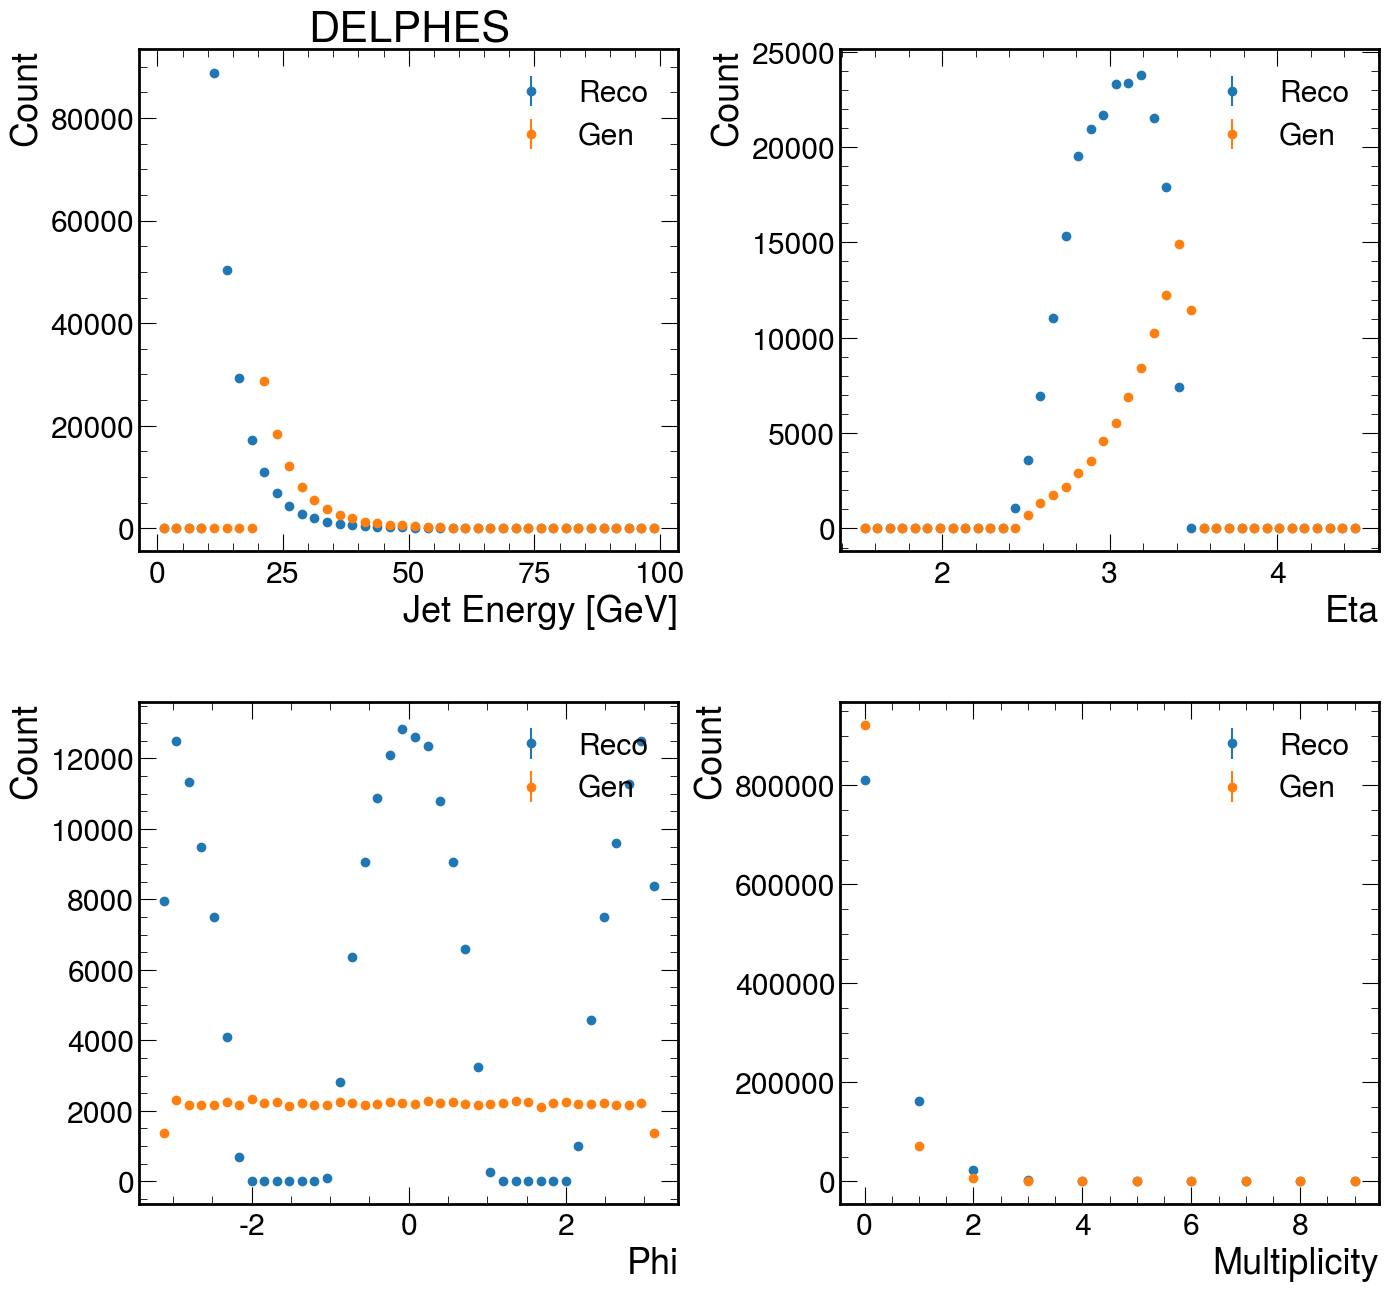

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'wspace': 0.3,'hspace': 0.3})

plt.sca(axs[0][0])


hist, bin_edges = np.histogram(ak.flatten(reco_dict["energy"]),range=(0,100),bins=40)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Reco")

hist, bin_edges = np.histogram(ak.flatten(gen_dict["energy"]),range=(0,100),bins=40)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Gen")
plt.legend()

#plt.yscale("log")
plt.xlabel('Jet Energy [GeV]')
plt.ylabel('Count')
plt.title("DELPHES")

plt.sca(axs[0][1])


hist, bin_edges = np.histogram(ak.flatten(reco_dict["eta"]),range=(1.5,4.5),bins=40)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Reco")

hist, bin_edges = np.histogram(ak.flatten(gen_dict["eta"]),range=(1.5,4.5),bins=40)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Gen")
plt.legend()

plt.xlabel('Eta')
plt.ylabel('Count')



plt.sca(axs[1][0])


hist, bin_edges = np.histogram(ak.flatten(reco_dict["phi"]),bins = 40, range=(-3.2,3.2))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Reco")

hist, bin_edges = np.histogram(ak.flatten(gen_dict["phi"]),bins = 40, range=(-3.2,3.2))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Gen")
plt.legend(loc="upper right")
#plt.ylim(0,1100)
plt.xlabel('Phi')
plt.ylabel('Count')


def get_multiplicity(data):
    return ak.Array([len(subarray) for subarray in data])

plt.sca(axs[1][1])


hist, bin_edges = np.histogram(get_multiplicity(reco_dict["energy"]),bins = 10, range=(0,10))
bin_centres = bin_edges[:-1]
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Reco")

hist, bin_edges = np.histogram(get_multiplicity(gen_dict["energy"]),bins = 10, range=(0,10))
bin_centres = bin_edges[:-1]
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=np.sqrt(hist),fmt="o", label="Gen")

plt.legend()

plt.xlabel('Multiplicity')
plt.ylabel('Count')